In [15]:
# 1️⃣ Imports & Configuration
import pandas as pd
import numpy as np
import optuna
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from optuna.samplers import TPESampler, RandomSampler
from optuna.integration import LightGBMPruningCallback
from optuna.pruners import SuccessiveHalvingPruner


In [16]:
# 2️⃣ Load & Inspect Data
df = pd.read_csv("../data/train.csv")
print("Shape:", df.shape)
df.head()


Shape: (381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [17]:
# 3️⃣ Preprocessing
df.drop(columns=["id"], inplace=True)

# Encode binary and categorical features
df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
df["Vehicle_Damage"] = df["Vehicle_Damage"].map({"Yes": 1, "No": 0})
df["Vehicle_Age"] = df["Vehicle_Age"].map({
    "< 1 Year": 0,
    "1-2 Year": 1,
    "> 2 Years": 2
})

X = df.drop("Response", axis=1)
y = df["Response"]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [18]:
# 4️⃣ Baseline LightGBM (using callbacks for early stopping)

baseline_model = lgb.LGBMClassifier(n_estimators=1000)

baseline_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=0)  # silences logging
    ]
)

y_pred_prob = baseline_model.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, y_pred_prob)
print(f"Baseline AUC: {baseline_auc:.4f}")


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.857968	valid_0's binary_logloss: 0.264859
Baseline AUC: 0.8580


In [19]:
# 4️⃣.5 Load Config YAML

import yaml

def load_search_config(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)

config = load_search_config("../config/search_config.yaml")


In [20]:
# 5️⃣ Optuna Objective with Pruning
def objective(trial):
    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "scale_pos_weight": 1.0  # Optional: trial.suggest_float("scale_pos_weight", 1.0, 5.0)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):
        dtrain = lgb.Dataset(X.iloc[train_idx], label=y.iloc[train_idx])
        dvalid = lgb.Dataset(X.iloc[valid_idx], label=y.iloc[valid_idx])

        gbm = lgb.train(
            param,
            dtrain,
            valid_sets=[dvalid],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                LightGBMPruningCallback(trial, "auc"),
                lgb.log_evaluation(period=0)
            ]
        )

        preds = gbm.predict(X.iloc[valid_idx])
        auc_scores.append(roc_auc_score(y.iloc[valid_idx], preds))

    return np.mean(auc_scores)


In [21]:
# 6️⃣ Run Optuna Study (TPESampler)
study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=50)

# Save study
with open("../outputs/best_params.json", "w") as f:
    json.dump(study.best_trial.params, f)

print(f"Best AUC: {study.best_value:.4f}")
print("Best Params:", study.best_params)


[I 2025-08-03 15:31:56,659] A new study created in memory with name: no-name-b76cfc96-e66f-42fb-a78c-b45c05abc71e


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[227]	valid_0's auc: 0.857615
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid_0's auc: 0.85651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's auc: 0.858223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.859704
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:02,560] Trial 0 finished with value: 0.8584541727743156 and parameters: {'learning_rate': 0.04651854585555216, 'num_leaves': 32, 'max_depth': 11, 'min_data_in_leaf': 93, 'feature_fraction': 0.8055042340349872, 'bagging_fraction': 0.7282699516857707, 'bagging_freq': 3, 'lambda_l1': 0.004893616962314094, 'lambda_l2': 0.000365174481237317}. Best is trial 0 with value: 0.8584541727743156.


Early stopping, best iteration is:
[138]	valid_0's auc: 0.860218
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.856686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.855303
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.857276
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's auc: 0.858542
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:05,974] Trial 1 finished with value: 0.8574018598671695 and parameters: {'learning_rate': 0.07664459168430289, 'num_leaves': 104, 'max_depth': 9, 'min_data_in_leaf': 21, 'feature_fraction': 0.7683517225192531, 'bagging_fraction': 0.6149860866647034, 'bagging_freq': 6, 'lambda_l1': 0.003470641818234779, 'lambda_l2': 0.00029508311377756107}. Best is trial 0 with value: 0.8584541727743156.
[I 2025-08-03 15:32:06,115] Trial 2 pruned. Trial was pruned at iteration 4.


Early stopping, best iteration is:
[60]	valid_0's auc: 0.859204
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:06,338] Trial 3 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:06,485] Trial 4 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:06,604] Trial 5 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:06,739] Trial 6 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:06,870] Trial 7 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:07,017] Trial 8 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:07,139] Trial 9 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:07,288] Trial 10 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:07,432] Trial 11 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:07,686] Trial 12 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.857156
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.856322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.857154
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.858667
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:10,345] Trial 13 finished with value: 0.8577139799398379 and parameters: {'learning_rate': 0.17671266121571486, 'num_leaves': 72, 'max_depth': 12, 'min_data_in_leaf': 39, 'feature_fraction': 0.861176225157357, 'bagging_fraction': 0.7988200443185606, 'bagging_freq': 5, 'lambda_l1': 3.60693853728719, 'lambda_l2': 5.14323044193371}. Best is trial 0 with value: 0.8584541727743156.


Early stopping, best iteration is:
[35]	valid_0's auc: 0.85927
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:10,534] Trial 14 pruned. Trial was pruned at iteration 16.
[I 2025-08-03 15:32:10,679] Trial 15 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:10,835] Trial 16 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:10,987] Trial 17 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:11,145] Trial 18 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:11,299] Trial 19 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:11,472] Trial 20 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:11,625] Trial 21 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:11,850] Trial 22 pruned. Trial was pruned at iteration 16.
[I 2025-08-03 15:32:12,014] Trial 23 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:12,165] Trial 24 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:12,383] Trial 25 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:12,548] Trial 26 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:12,705] Trial 27 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:12,939] Trial 28 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:13,105] Trial 29 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:13,264] Trial 30 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:13,475] Trial 31 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:13,919] Trial 32 pruned. Trial was pruned at iteration 64.
[I 2025-08-03 15:32:14,081] Trial 33 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:14,275] Trial 34 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:14,442] Trial 35 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:14,607] Trial 36 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:15,098] Trial 37 pruned. Trial was pruned at iteration 64.
[I 2025-08-03 15:32:15,252] Trial 38 pruned. Trial was pruned at iteration 4.
[I 2025-08-03 15:32:15,404] Trial 39 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:15,562] Trial 40 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:16,029] Trial 41 pruned. Trial was pruned at iteration 64.
[I 2025-08-03 15:32:16,261] Trial 42 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:16,494] Trial 43 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:16,642] Trial 44 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:17,077] Trial 45 pruned. Trial was pruned at iteration 64.
[I 2025-08-03 15:32:17,234] Trial 46 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:17,480] Trial 47 pruned. Trial was pruned at iteration 16.
[I 2025-08-03 15:32:17,694] Trial 48 pruned. Trial was pruned at iteration 16.


Training until validation scores don't improve for 50 rounds


[I 2025-08-03 15:32:17,867] Trial 49 pruned. Trial was pruned at iteration 4.


Training until validation scores don't improve for 50 rounds
Best AUC: 0.8585
Best Params: {'learning_rate': 0.04651854585555216, 'num_leaves': 32, 'max_depth': 11, 'min_data_in_leaf': 93, 'feature_fraction': 0.8055042340349872, 'bagging_fraction': 0.7282699516857707, 'bagging_freq': 3, 'lambda_l1': 0.004893616962314094, 'lambda_l2': 0.000365174481237317}


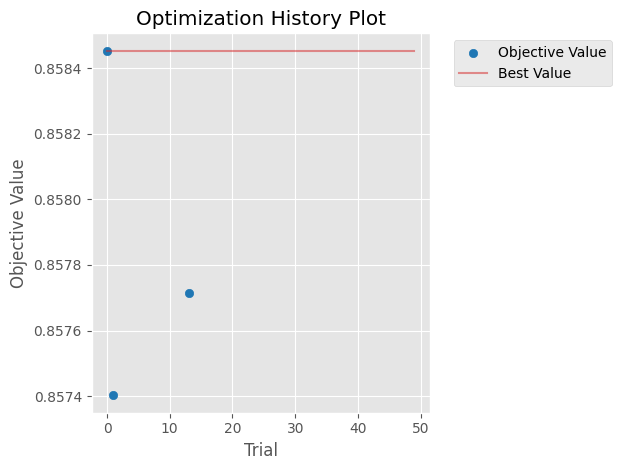

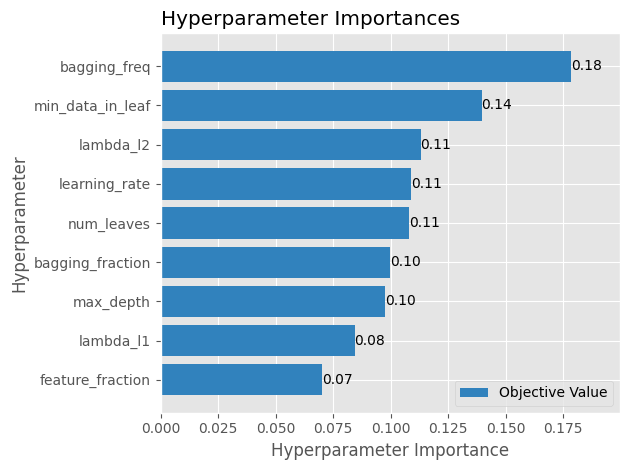

In [22]:
# 7️⃣ Optimization History & Importance
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.savefig("../outputs/optuna_history.png")
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.savefig("../outputs/param_importances.png")
plt.show()


In [23]:
# 8️⃣ Evaluate Final Model on Validation Set

best_model = lgb.LGBMClassifier(**study.best_params, n_estimators=1000)

best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=0)
    ]
)

final_preds = best_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, final_preds)
print(f"Final Tuned AUC: {final_auc:.4f}")


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.858757	valid_0's binary_logloss: 0.264152
Final Tuned AUC: 0.8588


In [24]:
# 9️⃣ SHAP Explainability (on sample to avoid long compute time)

import shap

# Sample 500 rows from validation set for faster SHAP computation
X_val_sample = X_val.sample(n=500, random_state=42)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sample)

# Summary plot
shap.summary_plot(shap_values, X_val_sample, show=False)
plt.savefig("../outputs/shap_summary.png")
plt.close()

# Interaction values (optional)
interaction_vals = explainer.shap_interaction_values(X_val_sample)
shap.summary_plot(interaction_vals, X_val_sample, show=False)
plt.savefig("../outputs/shap_interaction.png")
plt.close()


In [25]:
# 🔟 Hyperparameter Stability

stability_scores = []

for seed in [10, 20, 30]:
    X_train_, X_val_, y_train_, y_val_ = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    model = lgb.LGBMClassifier(**study.best_params, n_estimators=1000)

    model.fit(
        X_train_, y_train_,
        eval_set=[(X_val_, y_val_)],
        eval_metric="auc",
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(period=0)
        ]
    )

    preds = model.predict_proba(X_val_)[:, 1]
    score = roc_auc_score(y_val_, preds)
    stability_scores.append(score)

print("AUCs across splits:", [f"{s:.4f}" for s in stability_scores])
print(f"Mean: {np.mean(stability_scores):.4f}, Std: {np.std(stability_scores):.4f}")


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[246]	valid_0's auc: 0.85824	valid_0's binary_logloss: 0.264434
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.860143	valid_0's binary_logloss: 0.26374
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.859052	valid_0's binary_logloss: 0.264682
AUCs across splits: ['0.8582', '0.8601', '0.8591']
Mean: 0.8591, Std: 0.0008


In [26]:

test_df = pd.read_csv("../data/test.csv")

# Preprocess same as train
test_df.drop(columns=["id"], inplace=True)
test_df["Gender"] = test_df["Gender"].map({"Male": 1, "Female": 0})
test_df["Vehicle_Damage"] = test_df["Vehicle_Damage"].map({"Yes": 1, "No": 0})
test_df["Vehicle_Age"] = test_df["Vehicle_Age"].map({
    "< 1 Year": 0,
    "1-2 Year": 1,
    "> 2 Years": 2
})

# Predict
test_preds = best_model.predict_proba(test_df)[:, 1]

# Save predictions as raw probabilities
output_df = pd.DataFrame({
    "Row": range(len(test_df)),
    "Predicted_Probability": test_preds
})

output_df.to_csv("../outputs/final_predictions.csv", index=False)
print("✅ Saved test set predictions to outputs/final_predictions.csv")


✅ Saved test set predictions to outputs/final_predictions.csv
